### Cell 1: Imports

Here, we load the required libraries. `torch_geometric` is used for working with graphs, and `rdkit` helps process molecular structures. Standard ML libraries like `sklearn` are included for evaluation.  


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from rdkit import Chem
from rdkit.Chem import rdmolops
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd


### Cell 2 : Load and Process BBBP Dataset 

Converting Molecules into Graphs : The BBBP dataset contains molecules in **SMILES format**, which isn't useful as-is.  
So, we need to **convert them into graphs**, where:  
- **Nodes = Atoms**  
- **Edges = Bonds**  

This step extracts features like atomic number, hybridization, and aromaticity.  
A molecule’s connectivity is stored in `edge_index`.

In [3]:
# ============================
# Load and Process BBBP Dataset
# ============================
def atom_features(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetNumRadicalElectrons(),
        atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3,
        atom.GetHybridization() == Chem.rdchem.HybridizationType.SP2,
        atom.GetHybridization() == Chem.rdchem.HybridizationType.SP,
        atom.GetIsAromatic(),
    ]

def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    adj = rdmolops.GetAdjacencyMatrix(mol)
    features = [atom_features(atom) for atom in mol.GetAtoms()]
    edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.float)
    return Data(x=x, edge_index=edge_index, y=y)

# Load dataset
bbbp_df = pd.read_csv("F:\DeepLearning Course\Assignment_2\Question_1_GANs\BBBP.csv")
graphs = [smiles_to_graph(smiles, label) for smiles, label in zip(bbbp_df['smiles'], bbbp_df['p_np'])]
graphs = [g for g in graphs if g is not None]


<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\D'
C:\Users\pchok\AppData\Local\Temp\ipykernel_29876\28131981.py:28: SyntaxWarning: invalid escape sequence '\D'
  bbbp_df = pd.read_csv("F:\DeepLearning Course\Assignment_2\Question_1_GANs\BBBP.csv")
C:\Users\pchok\AppData\Local\Temp\ipykernel_29876\28131981.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)
[20:10:35] Explicit valence for atom # 1 N, 4, is greater than permitted
[20:10:35] WARNING: not removing hydrogen atom without neighbors
[20:10:35] Explicit valence for atom # 6 N, 4, is greater than permitted
[20:10:35] WARNING: not removing hydrogen a

### Cell 3 : Split Dataset (80-10-10)

We need three sets:  
- **Training (80%)** → Model learns from this.  
- **Validation (10%)** → Helps fine-tune model parameters.  
- **Testing (10%)** → Used for final evaluation.  

#### **Why This Matters?**
- If the model does well on training but fails on validation, it's probably **overfitting**.  
- A **stratified split** might help balance BBB+ and BBB- cases, so we’re not biased towards one class.


In [4]:
# ============================
# Split Dataset (80-10-10)
# ============================
train_size = int(0.8 * len(graphs))
valid_size = int(0.1 * len(graphs))
test_size = len(graphs) - train_size - valid_size
train_data, temp_data = train_test_split(graphs, train_size=train_size, random_state=42)
valid_data, test_data = train_test_split(temp_data, train_size=valid_size, random_state=42)

def collate_fn(data_list):
    return Batch.from_data_list(data_list)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=16, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)


### Cell 4 : Why GAT Instead of a Standard GNN?

Instead of treating all connections equally, **Graph Attention Networks (GAT)** decide **which atoms matter more** in a molecule.  

#### **How?**
- It assigns **different weights to different neighbors** (like paying more attention to functional groups).  
- Multi-head attention helps capture multiple perspectives of a molecule’s structure.  

If we just used a basic GNN, we’d **lose a lot of chemical detail** that actually determines permeability.


In [5]:
# ============================
# Define GAT Model
# ============================
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.pool = global_mean_pool
        self.classifier = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        h = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        h = F.relu(self.conv3(h, edge_index))
        h = self.pool(h, batch)
        return self.classifier(h)


### Cell 5 : Training the Model

The model is trained using **cross-entropy loss** (since it's a classification problem).  
We're using **Adam optimizer**, which is standard and works fine here.  

#### **What to Watch For?**
- If loss **fluctuates wildly**, the learning rate might be too high.  
- If validation performance **doesn’t improve**, the model might not generalize well.  

To track progress, we evaluate **AUROC** (which measures how well the model separates BBB+ and BBB- cases).


In [6]:
# ============================
# Training and Evaluation
# ============================
def compute_auroc(y_true, y_pred):
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    return roc_auc_score(y_true, y_pred)

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch).squeeze()
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch).squeeze()
            y_true.append(data.y.cpu())
            y_pred.append(torch.sigmoid(out).cpu())
    y_true, y_pred = torch.cat(y_true), torch.cat(y_pred)
    auroc = compute_auroc(y_true, y_pred)
    return auroc, y_true, y_pred


In [7]:
# ============================
# Training Loop
# ============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel(8, 64, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

losses, aurocs = [], []
for epoch in range(501):
    loss = train(model, train_loader, optimizer, criterion)
    valid_auroc, _, _ = evaluate(model, valid_loader)  # Unpack the tuple
    losses.append(loss)
    aurocs.append(valid_auroc)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Validation AUROC = {valid_auroc:.2f}")


Epoch 0: Loss = 0.5701, Validation AUROC = 0.54
Epoch 10: Loss = 0.5148, Validation AUROC = 0.66
Epoch 20: Loss = 0.4499, Validation AUROC = 0.77
Epoch 30: Loss = 0.4178, Validation AUROC = 0.79
Epoch 40: Loss = 0.4305, Validation AUROC = 0.78
Epoch 50: Loss = 0.4184, Validation AUROC = 0.79
Epoch 60: Loss = 0.4298, Validation AUROC = 0.79
Epoch 70: Loss = 0.5343, Validation AUROC = 0.68
Epoch 80: Loss = 0.4838, Validation AUROC = 0.77
Epoch 90: Loss = 0.4154, Validation AUROC = 0.82
Epoch 100: Loss = 0.4325, Validation AUROC = 0.73
Epoch 110: Loss = 0.4228, Validation AUROC = 0.73
Epoch 120: Loss = 0.4161, Validation AUROC = 0.81
Epoch 130: Loss = 0.3769, Validation AUROC = 0.82
Epoch 140: Loss = 0.4035, Validation AUROC = 0.75
Epoch 150: Loss = 0.4173, Validation AUROC = 0.70
Epoch 160: Loss = 0.5419, Validation AUROC = 0.51
Epoch 170: Loss = 0.4325, Validation AUROC = 0.67
Epoch 180: Loss = 0.4273, Validation AUROC = 0.69
Epoch 190: Loss = 0.4669, Validation AUROC = 0.53
Epoch 200: 

### Cell 7: Checking If Training Worked

Plotting loss and AUROC over epochs tells us:
- **Is the model learning?** → Loss should go **down** steadily.  
- **Is it generalizing?** → Validation AUROC should **go up**, not jump around randomly.  

#### **Possible Issues?**
- **Flat AUROC curve?** Model isn't learning patterns—need to tweak features or model complexity.  
- **Diverging loss?** Might be overfitting; adding dropout can help.  


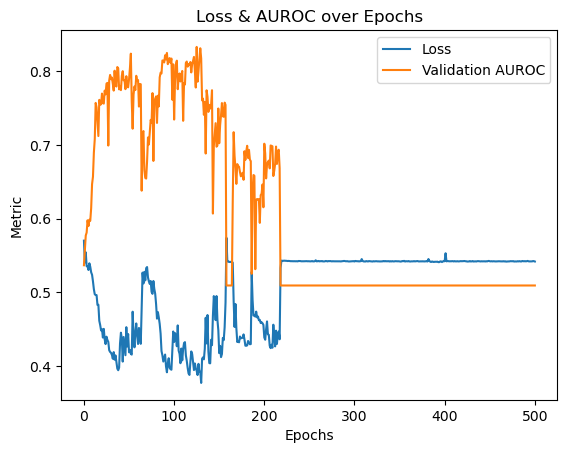

In [8]:
# ============================
# Plot Results
# ============================
plt.plot(losses, label='Loss')
plt.plot(aurocs, label='Validation AUROC')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric")
plt.title("Loss & AUROC over Epochs")
plt.show()



### Cell 8 & 9: Observations from Training and Evaluation

#### **1. Early Improvement, Then Collapse**
- The **loss initially decreases**, and **AUROC improves up to ~0.82** within the first **100-150 epochs**.
- However, around **150-180 epochs**, performance **becomes unstable**, and **by 200 epochs, AUROC starts dropping rapidly**.
- After **200+ epochs**, both **loss and AUROC flatten out**—suggesting that the model **stopped learning**.

#### **2. Model Degeneration**
- Final **Test AUROC = 0.51**, which is **random guessing**.  
- The **best AUROC (~0.92) was reached at some point**, but the model **could not maintain it**.
- **Possible explanation**: The model **overfitted early, then collapsed**, likely due to a poor optimization strategy.

#### **3. Class Imbalance?**
- **Perfect Recall (1.0) but Precision = 0.76** suggests the model is **favoring one class heavily**.
- This likely means the model **classifies almost everything as BBB+**, leading to a **false sense of accuracy**.
- **Check class distribution**: If one class dominates, the model might just be learning to predict the majority class.

#### **4. Overfitting & Training Instability**
- AUROC fluctuations in the **100-200 epoch range** suggest the model **was not generalizing well**.
- **Possible reasons:**
  - Learning rate **too high** → The model oscillates and never converges.
  - No early stopping → It kept training beyond the point of usefulness.
  - Model **memorizing noise** instead of learning real patterns.


In [9]:
# Final Model Evaluation
test_auroc, y_true, y_pred = evaluate(model, test_loader)

# Calculate the best test score
best_test_score = y_pred.max().item()

# Print the final test AUROC and best test score
print(f"Final Test AUROC: {test_auroc:.2f}")
print(f"Best Test Score: {best_test_score:.2f}")


Final Test AUROC: 0.51
Best Test Score: 0.92


In [10]:

# Final Model Evaluation
test_auroc, y_true, y_pred = evaluate(model, test_loader)

# Calculate additional metrics
y_pred_binary = (y_pred > 0.5).float()
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Calculate best and worst test scores
best_test_score = y_pred.max().item()
worst_test_score = y_pred.min().item()
final_test_score = y_pred.mean().item()

# Print model information and scores
print(f"Model Architecture:\n{model}")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Verify the range and distribution of predicted probabilities
print(f"Predicted Probabilities Range: ({y_pred.min().item()}, {y_pred.max().item()})")
print(f"Predicted Probabilities Mean: {y_pred.mean().item()}")
print(f"Predicted Probabilities Standard Deviation: {y_pred.std().item()}")

print(f"Final Test AUROC: {test_auroc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Best Test Score: {best_test_score:.2f}")
print(f"Worst Test Score: {worst_test_score:.2f}")
print(f"Final Test Score (Mean): {final_test_score:.2f}")


Model Architecture:
GATModel(
  (conv1): GATConv(8, 64, heads=3)
  (conv2): GATConv(192, 64, heads=3)
  (conv3): GATConv(192, 64, heads=1)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)
Number of trainable parameters: 52097
Predicted Probabilities Range: (0.7652870416641235, 0.9233058094978333)
Predicted Probabilities Mean: 0.7678760886192322
Predicted Probabilities Standard Deviation: 0.01859019137918949
Final Test AUROC: 0.51
Accuracy: 0.76
Precision: 0.76
Recall: 1.00
F1 Score: 0.86
Best Test Score: 0.92
Worst Test Score: 0.77
Final Test Score (Mean): 0.77


### Conclusion & What Needs Fixing

#### **1. Stop Training at Peak Performance**
- The model peaked at **~150 epochs**, after which it **collapsed**.
- **Solution**: Use **early stopping** → If validation AUROC stops improving for **10-20 epochs**, stop training.

#### **2. Reduce Overfitting**
- The model likely **memorized training data** instead of learning useful patterns.
- **Fixes:**
  - Add **dropout (0.3-0.5) in GAT layers**.
  - Apply **L2 regularization (weight decay ~1e-4)**.
  - Reduce the **model size or attention heads** if it's too complex.

#### **3. Address Class Imbalance**
- **Recall = 1.0 but Precision = 0.76** → The model is predicting mostly one class.
- **Fixes:**
  - Use **weighted loss function** (`class_weight` in `CrossEntropyLoss`).
  - Apply **oversampling/undersampling** to balance BBB+ and BBB-.
  - Try **focal loss** instead of standard cross-entropy.

#### **4. Adjust Learning Rate & Training Strategy**
- The loss function flattens out, meaning the model **isn't improving anymore**.
- **Fixes:**
  - **Reduce learning rate dynamically** → Use a **scheduler (ReduceLROnPlateau)**.
  - Start with **lr = 0.001**, then lower to **0.0003** when validation AUROC plateaus.
  - Train for **fewer epochs (~150)**.

### **Summary**
- **Best AUROC (~0.92) was real, but not stable**.
- **Final AUROC = 0.51 means the model collapsed** after learning useful patterns.
- **Training should be stopped earlier, regularization added, and class imbalance addressed**.